# Project IV Part 2: Implementing a Multi-View VAE for MNIST-SHVN

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import random

## Importing the datasets

In [ ]:
import torch
from torchvision import datasets, transforms


# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

In [ ]:
# MNIST dataset
batch_size = 64

# Download and load the training data
trainset_MNIST = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader_MNIST = torch.utils.data.DataLoader(trainset_MNIST, batch_size=batch_size, shuffle=True)

# Download and load the test data
testset_MNIST = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader_MNIST = torch.utils.data.DataLoader(testset_MNIST, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 77901047.68it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 7136123.35it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 106753077.87it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 3298792.86it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



In [ ]:
#SHVN dataset
batch_size = 64
# Download and load the training  data
trainset_SVHN = datasets.SVHN('~/.pytorch/SVHN_data/', split='train', download=True, transform=transform)
#Modification of the labels to represent the digit class (0-9).
trainset_SVHN.labels = torch.LongTensor(trainset_SVHN.labels.squeeze().astype(int)) % 10
trainloader_SVHN = torch.utils.data.DataLoader(trainset_SVHN, batch_size=batch_size, shuffle=True)

# Download and load the test data
testset_SVHN = datasets.SVHN('~/.pytorch/SVHN_data/', split='test', download=True, transform=transform)
#Modification of the labels to represent the digit class (0-9).
testset_SVHN.labels = torch.LongTensor(testset_SVHN.labels.squeeze().astype(int)) % 10
testloader_SVHN = torch.utils.data.DataLoader(testset_SVHN, batch_size=batch_size, shuffle=True)

100%|██████████| 182040794/182040794 [00:58<00:00, 3107806.42it/s]


100%|██████████| 64275384/64275384 [00:12<00:00, 5144327.62it/s]


In [ ]:
import numpy as np
import torch
from torchvision import transforms

def create_sorted_pairs(dataset1, dataset2):
    # Sort labels
    label1, idx1 = dataset1.targets.sort()
    label2, idx2 = dataset2.labels.sort()

    # Create pairs and store them in a list
    data_pairs1 = []
    data_pairs2 = []
    labels = []

    for l in label1.unique():
        new_idx1, new_idx2 = [], []
        l_idx1, l_idx2 = idx1[label1 == l], idx2[label2 == l]
        n = min(l_idx1.size(0), l_idx2.size(0))
        l_idx1, l_idx2 = l_idx1[:n], l_idx2[:n]

        new_idx1 = l_idx1[torch.randperm(n)]
        new_idx2 = l_idx2[torch.randperm(n)]

        for i in range(n):
            data_pairs1.append(dataset1.data[new_idx1[i]].unsqueeze(0))
            data_pairs2.append(torch.from_numpy(dataset2.data[new_idx2[i]]))
            labels.append([label1[new_idx1[i]].item(), label2[new_idx2[i]].item()])

    # Shuffle indices
    shuffled_indices = torch.randperm(len(data_pairs1))

    # Apply shuffling
    data_pairs1 = [data_pairs1[i] for i in shuffled_indices]
    data_pairs2 = [data_pairs2[i] for i in shuffled_indices]
    labels = torch.tensor(labels)[shuffled_indices]

    return data_pairs1,data_pairs2, labels



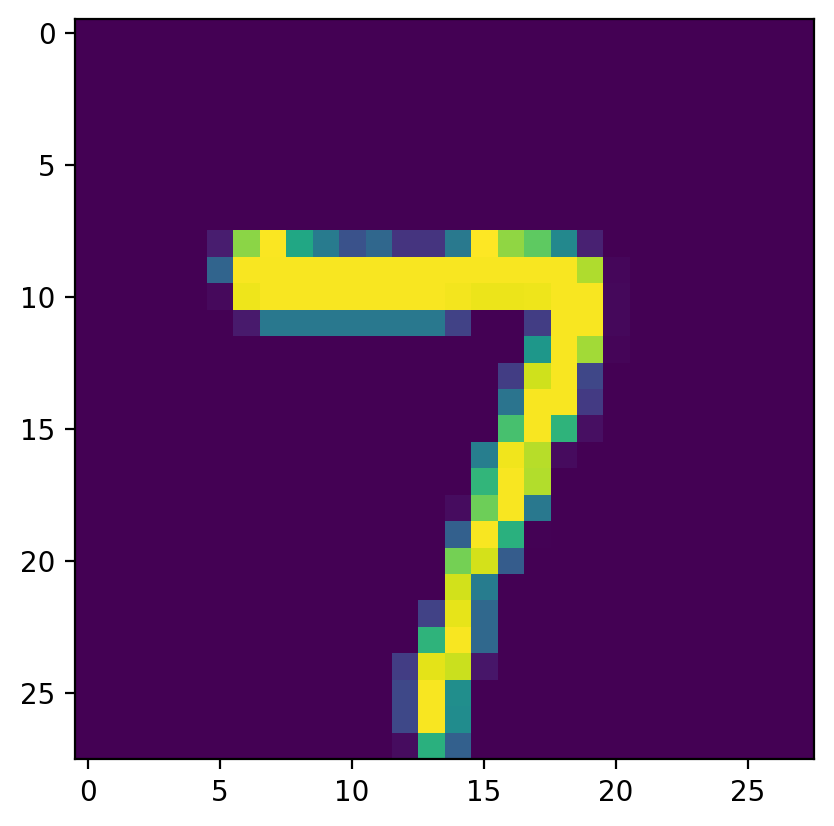

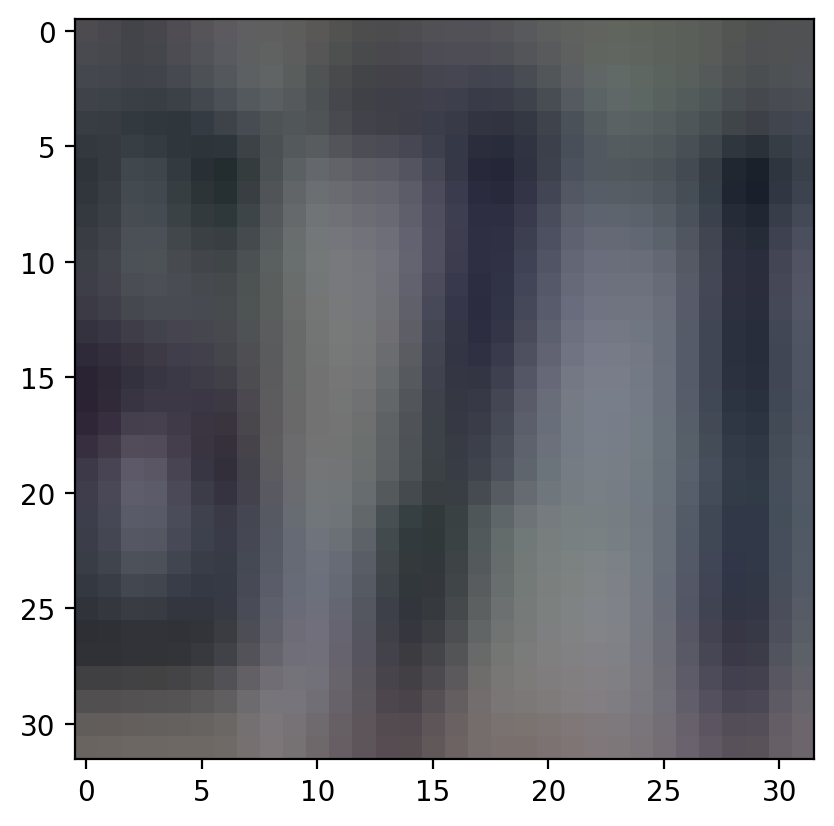

In [ ]:
import warnings
warnings.filterwarnings("ignore")
data_pairs1,data_pairs2, labels= create_sorted_pairs(trainset_MNIST, trainset_SVHN)

#Plot an example of the paired data
plt.figure()
plt.imshow(data_pairs1[0][0, :, :])
plt.show()

plt.figure()
plt.imshow(data_pairs2[0].numpy().transpose(1,2,0)[:,:,:])
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Create DataLoader for MNIST
trainloader_MNIST_paired = DataLoader(TensorDataset(torch.stack(data_pairs1), labels),
                                       batch_size=64, shuffle=False)

# Create DataLoader for SVHN
trainloader_SVHN_paired = DataLoader(TensorDataset(torch.stack(data_pairs2), labels),
                                       batch_size=64, shuffle=False)


## Encoder & decoder MNIST

In [ ]:
class encoder_MNIST(nn.Module):

    def __init__(self,dimz,channels=3,var_x=0.1):

        super().__init__()

        self.dimz = dimz

        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=32,
                               kernel_size=2, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32,
                               kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=3, stride=2, padding=0)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=256,
                               kernel_size=3, stride=1, padding=0)

        # Adjust the linear layer to output dimx * 2 values
        self.linear = nn.Linear(256, dimz * 2)
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()


    def forward(self, x):
        z = self.relu(self.conv1(x))
        z = self.relu(self.conv2(z))
        z = self.relu(self.conv3(z))
        z = self.relu(self.conv4(z))
        z = z.view(z.size(0), -1)
        z = self.linear(z)
        return z

    def encode_and_sample(self,x,flag_sample=True):

        z = self.forward(x)
        # The mean is the first dimz components of the forward output
        mu = z[:, :self.dimz]

        # We compute the variance from the last dimz components using a
        var = self.softplus(0.5 * z[:, self.dimz:])
        sample = None
        if(flag_sample==True):

            eps = torch.randn_like(var)
            sample = mu + eps*(var**0.5)

        return mu,var,sample


In [ ]:
class decoder_MNIST(nn.Module):

    def __init__(self,dimz,channels=3,var_x=0.1):

        super().__init__()


        self.linear = nn.Linear(dimz,256)

        self.relu = nn.ReLU()

        self.tanh = nn.Tanh()

        # Adjusted parameters for tconv1
        self.tconv1 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1, padding=0)

        # Adjusted parameters for tconv2
        self.tconv2 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=0)

        # Adjusted parameters for tconv3
        self.tconv3 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0)

        # Adjusted parameters for tconv4
        self.tconv4 = nn.ConvTranspose2d(32, channels, kernel_size=2, stride=2, padding=1)



    def forward(self,z):
        x = self.relu(self.linear(z).view(-1,256,1,1))
        x = self.relu(self.tconv1(x))
        x = self.relu(self.tconv2(x))
        x = self.relu(self.tconv3(x))
        x = self.tanh(self.tconv4(x))
        return x

    def decode(self,z):

        # This function simply calls the forward method

        return self.forward(z)

##Encoder & decoder SVHN

In [ ]:
class encoder_SVHN(nn.Module):

    def __init__(self, dimz, channels=3, var_x=0.1):

        super().__init__()

        self.dimz = dimz

        self.conv1 = nn.Conv2d(in_channels=channels, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64,  kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=4, stride=2, padding=0)

        # Adjust the linear layer to output dimz * 2 values
        self.linear = nn.Linear(256, dimz * 2)
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()

    def forward(self, x):
        z = self.relu(self.conv1(x))
        z = self.relu(self.conv2(z))
        z = self.relu(self.conv3(z))
        z = self.relu(self.conv4(z))
        z = z.view(z.size(0), -1)
        z = self.linear(z)
        return z

    def encode_and_sample(self, x, flag_sample=True):

        z = self.forward(x)
        # The mean is the first dimz components of the forward output
        mu = z[:, :self.dimz]

        # We compute the variance from the last dimz components using a
        var = self.softplus(0.5 * z[:, self.dimz:])
        sample = None
        if flag_sample:
            eps = torch.randn_like(var)
            sample = mu + eps * (var**0.5)

        return mu, var, sample


In [ ]:
import torch.nn as nn

class decoder_SVHN(nn.Module):

    def __init__(self, dimz, channels=3, var_x=0.1):

        super().__init__()

        self.linear = nn.Linear(dimz, 256)

        self.relu = nn.ReLU()

        self.tanh = nn.Tanh()

        # Adjust the output channel of the first transpose convolutional layer
        self.tconv1 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=0)

        self.tconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)

        self.tconv3 = nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1)

        self.tconv4 = nn.ConvTranspose2d(32, channels, kernel_size=4, stride=2, padding=1)

    def forward(self, z):
        x = self.relu(self.linear(z).view(-1, 256, 1, 1))
        x = self.relu(self.tconv1(x))
        x = self.relu(self.tconv2(x))
        x = self.relu(self.tconv3(x))
        x = self.tanh(self.tconv4(x))
        return x

    def decode(self, z):
        # This function simply calls the forward method
        return self.forward(z)


## Testing the encoders and decoders

torch.Size([64, 1, 28, 28])


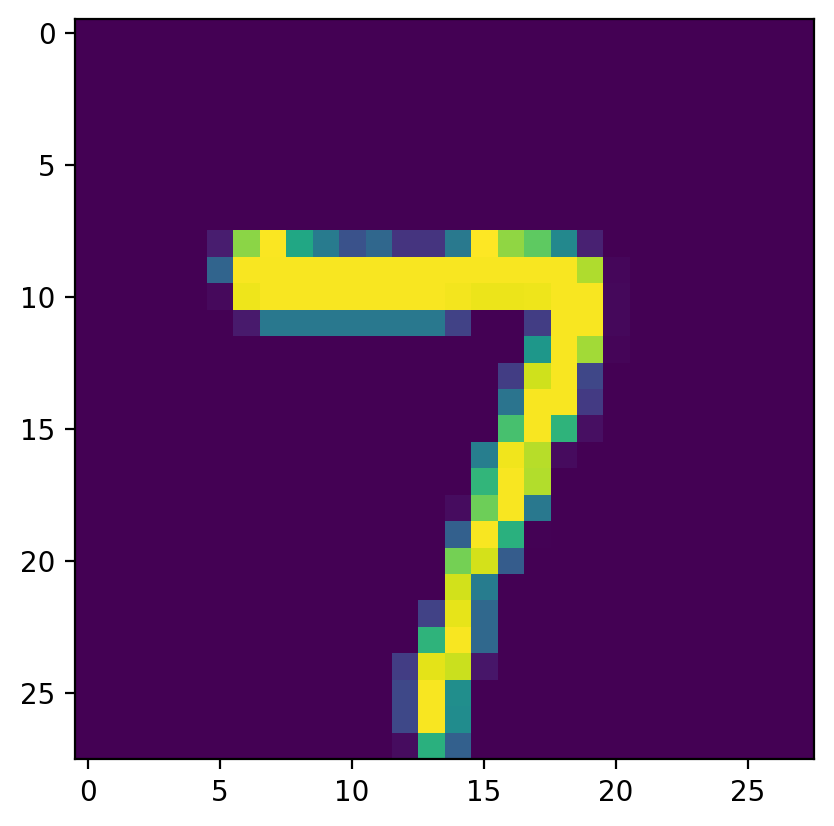

torch.Size([64, 10])
torch.Size([64, 1, 28, 28])


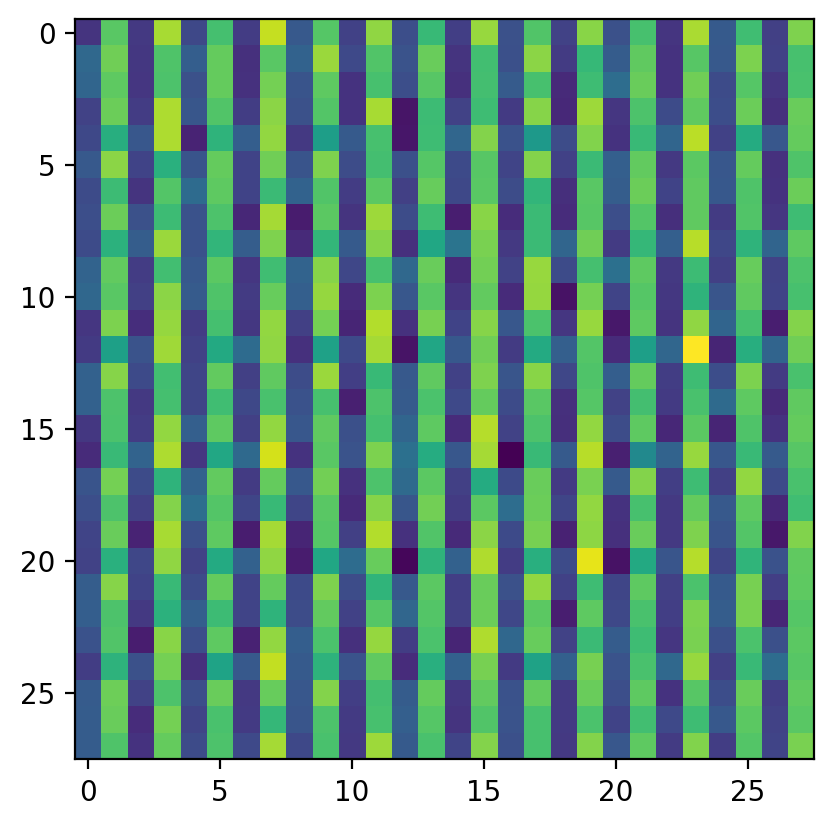

In [ ]:
train = iter(trainloader_MNIST_paired)
i,l = next(train)

print(i.size())
plt.imshow(i[0][0, :,:])
plt.show()

enc = encoder_MNIST(dimz = 10,channels=1,var_x=0.1)
dec = decoder_MNIST(dimz = 10,channels=1)

mu_z,var_z, sample_z = enc.encode_and_sample(i.float(), flag_sample=True)
print(sample_z.size())
i_new = dec.forward(mu_z)
plt.imshow(i_new.detach().numpy()[0,0,:,:])
print(i_new.size())

torch.Size([64, 3, 32, 32])


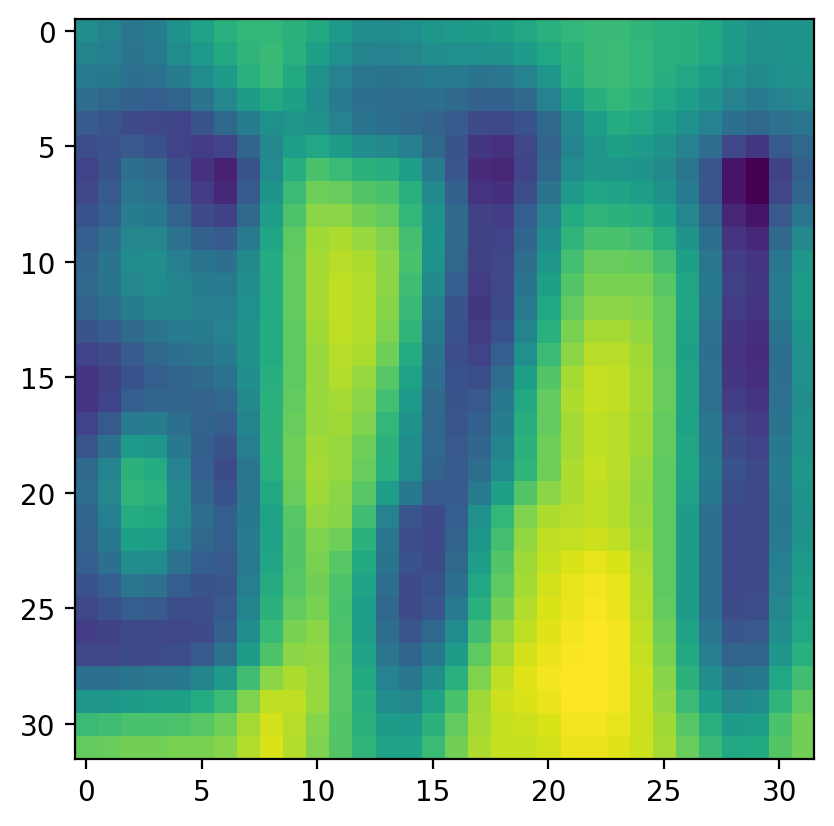

torch.Size([64, 10])
torch.Size([64, 3, 32, 32])


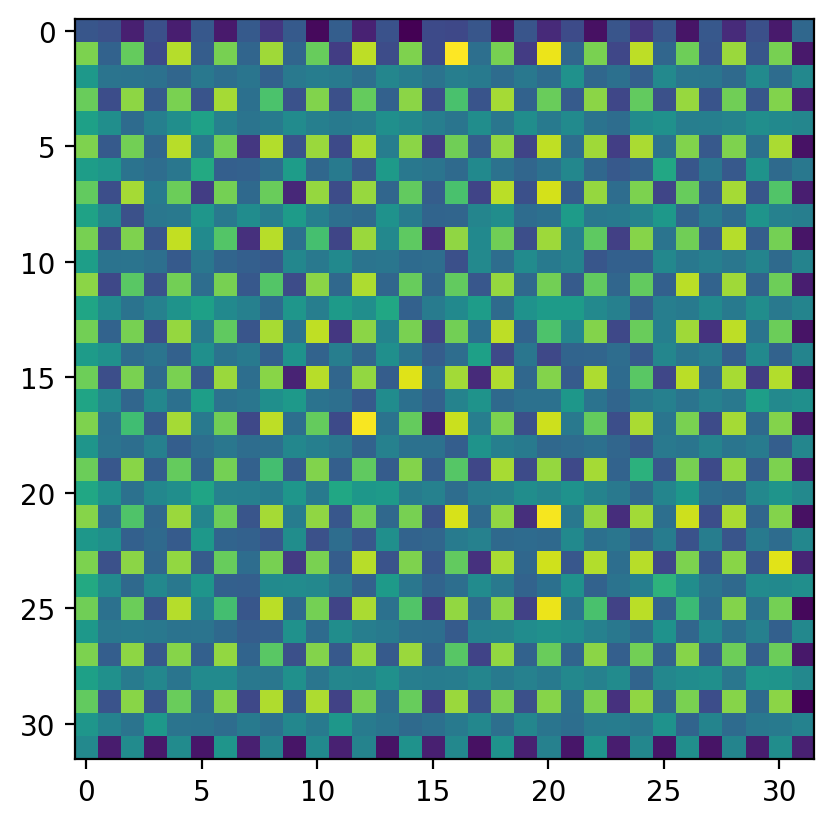

In [ ]:
train = iter(trainloader_SVHN_paired)
i,l = next(train)

print(i.size())
plt.imshow(i[0][0,:,:])
plt.show()

enc = encoder_SVHN(dimz = 10,channels=3,var_x=0.1)
dec = decoder_SVHN(dimz = 10,channels=3)

mu_z,var_z, sample_z = enc.encode_and_sample(i.float(), flag_sample=True)
print(sample_z.size())
i_new = dec.forward(mu_z)
plt.imshow(i_new.detach().numpy()[0,0,:,:])
print(i_new.size())

## Multi-View VAE

In [ ]:
def eval_Gaussian_LL(x,mu_x,var_x):

    # x is a mini-batch of images. It has dimension [Batch,1,dimx,dimx]

    # mu_x is a mini-batch of reconstructed images. It has dimension [Batch,1,dimx,dimx]

    # var_x is a torch constant

    D = x.shape[1] * x.shape[2] * x.shape[3]   # Dimension of the image

    x = x.reshape(-1, D)

    mu_x = mu_x.reshape(-1, D)

    var_x = torch.ones_like(mu_x) * var_x

    # Constant term in the gaussian distribution
    cnt = D * np.log(2 * np.pi) + torch.sum(torch.log(var_x), dim=-1)

    # log-likelihood per datapoint

    logp_data = -0.5 * (cnt + torch.sum((x - mu_x) * var_x ** -1 * (x - mu_x), dim=-1))

    # Accumulated Gaussian log-likelihood for all datapoints in the batch
    logp = torch.sum(logp_data)

    return logp, logp_data

In [ ]:
class MultiViewVAE(nn.Module):
    def __init__(self, dimz, var_x, channelsMNIST,channelsSHVN):
        super(MultiViewVAE, self).__init__()

        self.var_x = var_x
        self.dimz = dimz

        self.encoderMNIST = encoder_MNIST(self.dimz, channelsMNIST, self.var_x)
        self.decoderMNIST = decoder_MNIST(self.dimz, channelsMNIST, self.var_x)

        self.encoderSHVN = encoder_SVHN(self.dimz, channelsSHVN, self.var_x)
        self.decoderSHVN = decoder_SVHN(self.dimz, channelsSHVN, self.var_x)


    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward_MNIST(self, x):
        x = x.float()
        mu_z, var_z, sample_z = self.encoderMNIST.encode_and_sample(x)
        mu_x = self.decoderMNIST.forward(sample_z)

        return mu_x, mu_z, var_z

    def forward_SHVN(self, x):
        x = x.float()
        mu_z, var_z, sample_z = self.encoderSHVN.encode_and_sample(x)
        mu_x = self.decoderSHVN.forward(sample_z)

        return mu_x, mu_z, var_z

    def loss_function(self, x, mu_x, mu_z, var_z):

        # We evaluate the loglikelihood in the batch using the function provided above

        logp, _ = eval_Gaussian_LL(x, mu_x, self.var_x)

        # KL divergence between q(z) and N()
        # see Appendix B from VAE paper:
        # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
        # https://arxiv.org/abs/1312.6114

        KLz = -0.5 * torch.sum(1 + torch.log(var_z) - mu_z.pow(2) - var_z)

        # To maximize ELBO we minimize loss (-ELBO)
        return -logp + KLz, -logp, KLz



In [ ]:
class MultiViewVAE_extended(MultiViewVAE):

    def __init__(self, dimz, channelsMNIST,channelsSHVN, var_x=0.1,lr=1e-3,epochs=20,save_folder='./',restore=False):

        super(MultiViewVAE_extended, self).__init__(dimz=dimz, var_x=var_x, channelsMNIST=channelsMNIST,channelsSHVN=channelsSHVN)

        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.dimz = dimz

        self.save_folder = save_folder

        if(restore==True):
            state_dict = torch.load(self.save_folder+'VAE_checkpoint.pth')
            self.load_state_dict(state_dict)

        self.loss_during_training = []
        self.reconstruc_during_training = []
        self.KL_during_training = []

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def trainloop(self, trainloaderMNIST, trainloaderSHVN):

        self.train()
        for e in range(int(self.epochs)):

            train_loss = 0
            train_rec = 0
            train_kl_l = 0

            loss = 0
            rec = 0
            kl_l = 0

            idx_batch = 0

            print(f'Starting {e+1}/{self.epochs} epoch')
            counter = 0

            for (imagesMNIST, labelsMNIST), (imagesSHVN, labelsSHVN) in zip(trainloaderMNIST, trainloaderSHVN):

              random_var = random.random()
              counter += 1
              if counter%100 == 0:
                print(f'  {counter}/875 batches analyzed in epoch number {e}')

              imagesMNIST = imagesMNIST.to(self.device)
              imagesSHVN = imagesSHVN.to(self.device)

              self.optim.zero_grad()

              mu_xMNIST, mu_zMNIST, var_zMNIST = self.forward_MNIST(imagesMNIST)
              mu_xSHVN, mu_zSHVN, var_zSHVN = self.forward_SHVN(imagesSHVN)

              lossMNIST, recMNIST, kl_lMNIST = self.loss_function(imagesMNIST, mu_xMNIST, mu_zMNIST, var_zMNIST)
              lossSHVN, recSHVN, kl_lSHVN = self.loss_function(imagesSHVN, mu_xSHVN, mu_zSHVN, var_zSHVN)

              #if random_var < 0.9 and random_var < 0.1:
                #print('Both selected')
              mu_zproduct = (var_zMNIST * mu_zSHVN + var_zSHVN * mu_zMNIST)/(var_zMNIST + var_zSHVN)
              var_zproduct = 1/(1/var_zMNIST + 1/var_zSHVN)
              KL_total = -0.5 * torch.sum(1 + torch.log(var_zproduct) - mu_zproduct.pow(2) - var_zproduct)

              rec = recMNIST + recSHVN
              loss = recMNIST + recSHVN + KL_total
              kl_l = KL_total

              loss.backward()
              train_loss += loss.item()
              train_rec += rec.item()
              train_kl_l += kl_l.item()
              self.optim.step()

              if(idx_batch%10==0):

                  torch.save(self.state_dict(), self.save_folder + 'VAE_checkpoint.pth')

              idx_batch += 1

            self.loss_during_training.append(train_loss/(len(trainloaderMNIST) + len(trainloaderSHVN)))
            self.reconstruc_during_training.append(train_rec/(len(trainloaderMNIST) + len(trainloaderSHVN)))
            self.KL_during_training.append(train_kl_l/(len(trainloaderMNIST) + len(trainloaderSHVN)))

            if(e%1==0):

              #torch.save(self.state_dict(), self.save_folder + 'VAE_checkpoint.pth')
              print('Train Epoch: {} \tLoss: {:.6f}'.format(e,self.loss_during_training[-1]))

    def sample(self,num_imgs):

        with torch.no_grad():

            eps = torch.randn([num_imgs,self.dimz]).to(self.device)

            x_sample = self.decoder.decode(eps)

            return x_sample.to("cpu").detach()

In [ ]:
multiview_vae = MultiViewVAE_extended(dimz = 10, channelsMNIST = 1,channelsSHVN=3, var_x=0.1, lr=1e-7, epochs=25)
multiview_vae.trainloop(trainloader_MNIST_paired, trainloader_SVHN_paired)


Starting 1/25 epoch
  100/875 batches analyzed in epoch number 0
  200/875 batches analyzed in epoch number 0
  300/875 batches analyzed in epoch number 0
  400/875 batches analyzed in epoch number 0
  500/875 batches analyzed in epoch number 0
  600/875 batches analyzed in epoch number 0
  700/875 batches analyzed in epoch number 0
  800/875 batches analyzed in epoch number 0
Train Epoch: 0 	Loss: 8707176422.494869
Starting 2/25 epoch
  100/875 batches analyzed in epoch number 1
  200/875 batches analyzed in epoch number 1
  300/875 batches analyzed in epoch number 1
  400/875 batches analyzed in epoch number 1
  500/875 batches analyzed in epoch number 1
  600/875 batches analyzed in epoch number 1
  700/875 batches analyzed in epoch number 1
  800/875 batches analyzed in epoch number 1
Train Epoch: 1 	Loss: 8707003562.070696
Starting 3/25 epoch
  100/875 batches analyzed in epoch number 2
  200/875 batches analyzed in epoch number 2
  300/875 batches analyzed in epoch number 2
  400

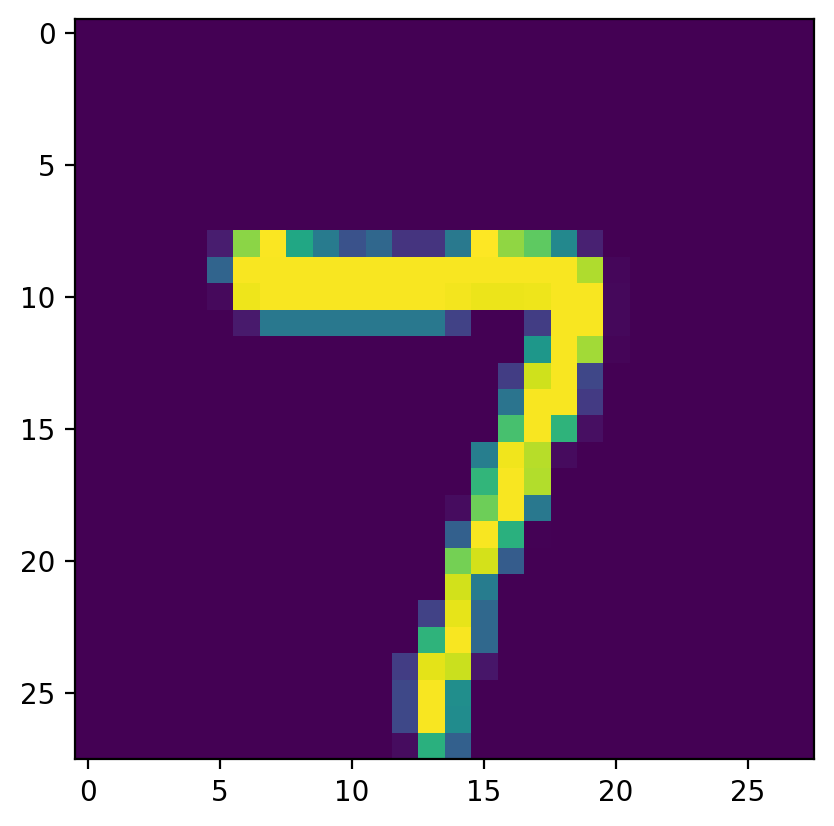

<function matplotlib.pyplot.show(close=None, block=None)>

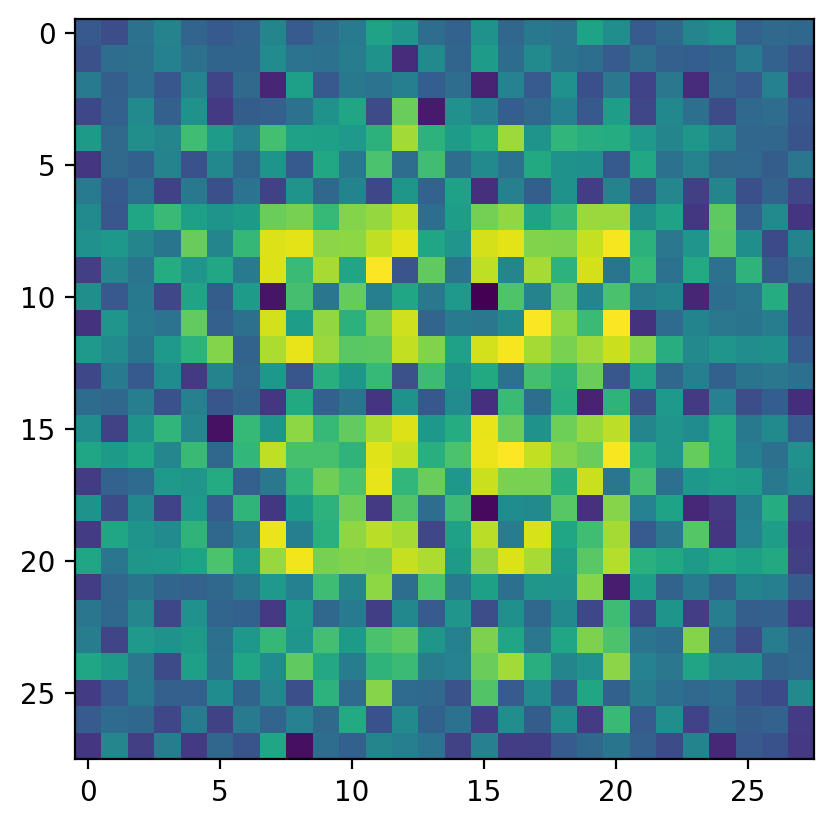

In [ ]:
train = iter(trainloader_MNIST_paired)
i,l = next(train)
i_afterMNIST,_,_ = multiview_vae.forward_MNIST(i)

plt.figure
plt.imshow(i[0,0,:,:])
plt.show()

plt.figure
plt.imshow(i_afterMNIST[0,0,:,:].detach())
plt.show

## Cross domain generation

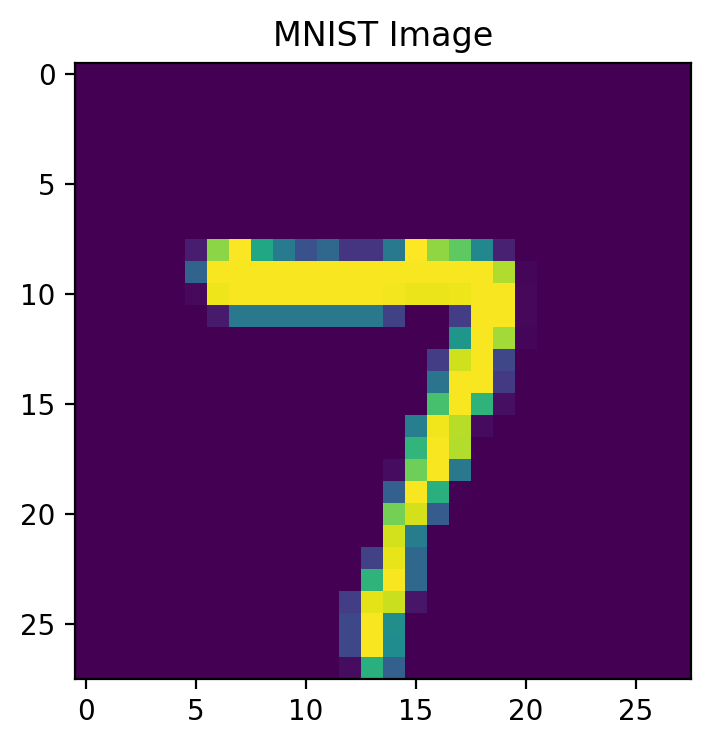

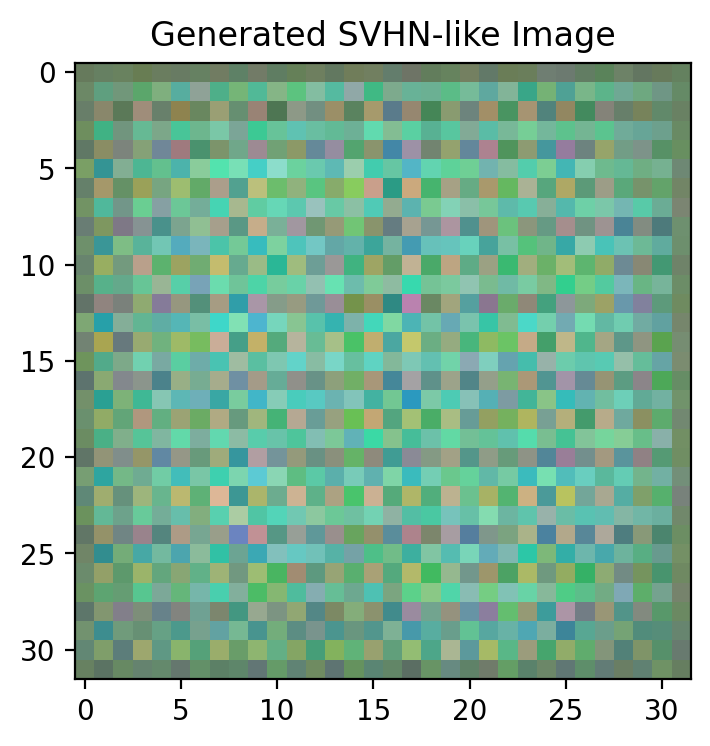

In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


# Get a random MNIST image
mnist_image, _ = next(iter(trainloader_MNIST_paired))
mnist_image = mnist_image.to("cuda" if torch.cuda.is_available() else "cpu")

# Encode the MNIST image to obtain latent representation
with torch.no_grad():
    _, mu_z_mnist, _ = multiview_vae.forward_MNIST(mnist_image)

# Use Latent Representation to Generate SVHN-like Image
with torch.no_grad():
    svhn_image = multiview_vae.decoderSHVN.decode(mu_z_mnist)

# Display the MNIST and generated SVHN-like images
mnist_image = mnist_image.cpu().numpy()
svhn_image = svhn_image.cpu().numpy()
svhn_image_normalized = (svhn_image - svhn_image.min()) / (svhn_image.max() - svhn_image.min())

plt.figure(figsize=(8, 4))
plt.imshow(mnist_image[0,0,:,:])
plt.title('MNIST Image')
plt.show()

plt.figure(figsize=(8, 4))
plt.imshow(svhn_image_normalized[0,:,:,:].transpose(1,2,0))
plt.title('Generated SVHN-like Image')
plt.show()


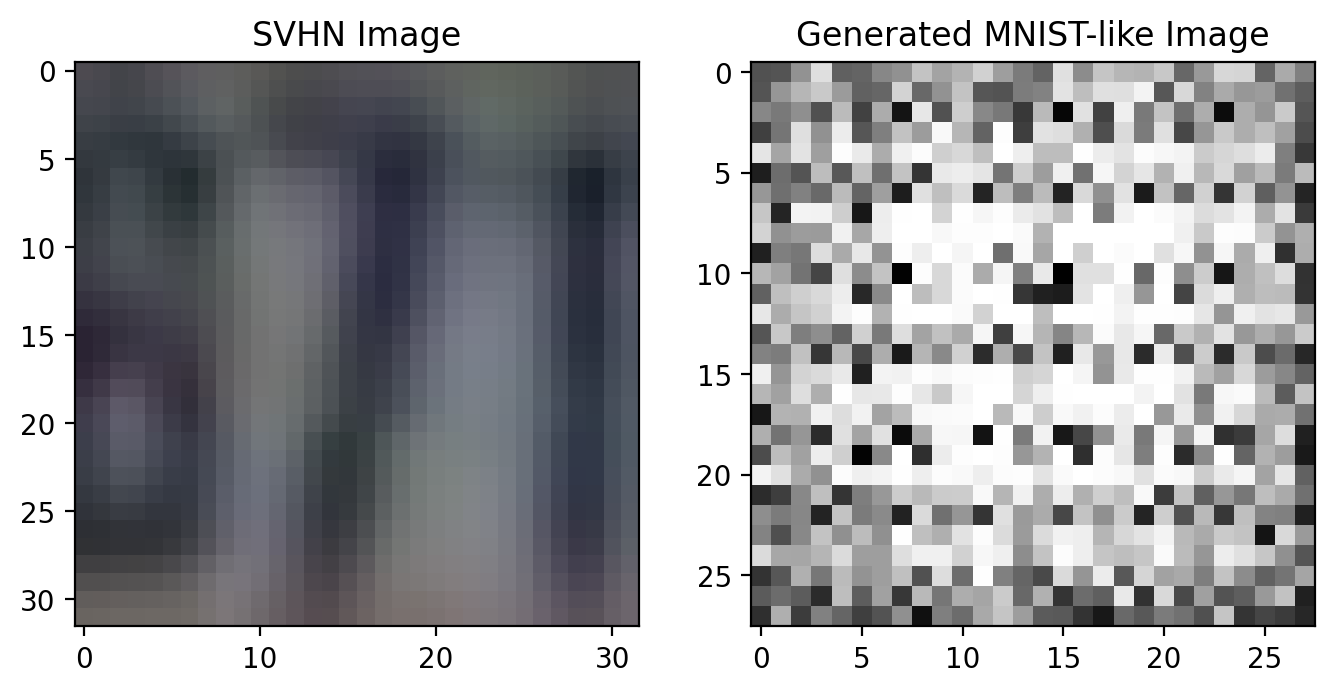

In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


# Get a random SVHN image
svhn_image, _ = next(iter(trainloader_SVHN_paired))
svhn_image = svhn_image.to("cuda" if torch.cuda.is_available() else "cpu")

# Encode the SVHN image to obtain latent representation
with torch.no_grad():
    _, mu_z_svhn, _ = multiview_vae.forward_SHVN(svhn_image)

# Use Latent Representation to Generate MNIST-like Image
with torch.no_grad():
    mnist_image = multiview_vae.decoderMNIST.decode(mu_z_svhn)

# Convert images to NumPy arrays
mnist_image = mnist_image.cpu().numpy()
svhn_image = svhn_image.cpu().numpy()

# Normalize pixel values to [0, 1]
mnist_image_normalized = (mnist_image - mnist_image.min()) / (mnist_image.max() - mnist_image.min())
svhn_image_normalized = (svhn_image - svhn_image.min()) / (svhn_image.max() - svhn_image.min())

# Display the SVHN and generated MNIST-like images
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(svhn_image_normalized[0,:,:,:].transpose(1,2,0))
plt.title('SVHN Image')

plt.subplot(1, 2, 2)
plt.imshow(mnist_image_normalized[0, 0, :, :], cmap='gray')
plt.title('Generated MNIST-like Image')

plt.show()


In [ ]:
from sklearn.manifold import TSNE
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
i= i.to(device)

z_batch,_,_ = my_vae.encoder.encode_and_sample(i)

latent_tsne = TSNE(n_components=2).fit_transform(z_batch.to("cpu").detach().numpy())
import seaborn as sns

def tsne_visualization(encoder, dataloader, view_name):
    encoder.eval()
    latent_vectors = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to("cuda" if torch.cuda.is_available() else "cpu")
            _, mu_z, _ = encoder(images)
            latent_vectors.append(mu_z.cpu().numpy())

    latent_vectors = np.concatenate(latent_vectors, axis=0)

    # Apply t-SNE
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(latent_vectors)

    # Plot the t-SNE visualization
    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels.numpy(), palette="viridis", legend="full")
    plt.title(f't-SNE Visualization of Latent Space ({view_name} View)')
    plt.show()

# Visualize t-SNE for MNIST View
tsne_visualization(multiview_vae.encoderMNIST, testloader_MNIST, "MNIST")

# Visualize t-SNE for SHVN View
tsne_visualization(multiview_vae.encoderSHVN, testloader_SVHN, "SHVN")
